 # Analysis of the Pagination Dataset

# Table of Contents
* [Preliminaries](#Preliminaries)
	* [Main parameters](#Main-parameters)
	* [Tools](#Tools)
	* [Reading the instances](#Reading-the-instances)
* [Difficulty and average multiplicity](#Difficulty-and-average-multiplicity)
	* [[Sec. 4.2] Measuring the difficulty of a given instance](#[Sec.-4.2]-Measuring-the-difficulty-of-a-given-instance)
		* [Number of instances by difficulty](#Number-of-instances-by-difficulty)
		* [Correlation between the difficulty and the size of the best pagination](#Correlation-between-the-difficulty-and-the-size-of-the-best-pagination)
	* [[Sec. 4.3] Predicting the difficulty of a given instance](#[Sec.-4.3]-Predicting-the-difficulty-of-a-given-instance)
		* [[Fig. 4] Number of instances by average multiplicity](#[Fig.-4]-Number-of-instances-by-average-multiplicity)
		* [[Fig. 5] Average difficulty by average multiplicity](#[Fig.-5]-Average-difficulty-by-average-multiplicity)
* [[Sec. 4.4] Discussion](#[Sec.-4.4]-Discussion)
	* [[Sec. 4.4.1] Behavior of the integer program](#[Sec.-4.4.1]-Behavior-of-the-integer-program)
	* [[Sec. 4.4.2] Comparison of the heuristic methods](#[Sec.-4.4.2]-Comparison-of-the-heuristic-methods)
		* [[Fig. 6] Performance of the main heuristics](#[Fig.-6]-Performance-of-the-main-heuristics)
		* [[Fig. 7] Relative quality of the five main heuristics](#[Fig.-7]-Relative-quality-of-the-five-main-heuristics)
	* [Exact algorithms vs. heuristics](#Exact-algorithms-vs.-heuristics)
	* [Grouping GA vs. the other heuristics](#Grouping-GA-vs.-the-other-heuristics)


# Preliminaries

This notebook generates every plot and numerical result mentioned or alluded in Section 4 of [_Algorithms for the Pagination Problem, a Bin Packing with Overlapping Items_](http://arxiv.org/abs/1605.00558).

## Main parameters

In [ ]:
from collections import OrderedDict

INPUT_PATH = "gauss/"
(MIN_PREFIX, MAX_PREFIX) = ("C015", "C055") # for instance filenames
OUTPUT_PATH = "plots/"
WINDOW = 150 # size of the subsets of instances used as a moving window

SOLVER_NAMES = OrderedDict([
    ("GeneticGroup", "Grouping GA"),
    ("GeneticStandard", "Standard GA"),
    ("OverloadAndRemove", "Overload-and-Remove"),
    ("OverloadAndRemovePresort", "Overload-and-Remove (with presort)"),
    ("BestFusion", "Best Fusion"),
    ("FirstFit", "First Fit"),
])
EXCLUDED_SOLVER_NAMES = {"OverloadAndRemovePresort"} # excluded from certain plots
solvers = ["solvers" + name for name in SOLVER_NAMES.keys()]
times = ["times" + name for name in SOLVER_NAMES.keys()]

## Tools

In [ ]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import Locator

In [ ]:
!pip install seaborn

In [ ]:
import seaborn as sns
sns.set_style("white")
sns.set_context("paper", font_scale=2)
sns.set_palette(sns.color_palette("Set1", 5))

In [ ]:
def plot_linear_regression(x, y):
    fit = np.polyfit(x, y, deg=1)
    plt.plot(x, fit[0] * x + fit[1])
    print("Pearson: %.03f." % x.corr(y))

In [ ]:
!pip install pandas --upgrade

## Reading the instances

Create a DataFrame from all the JSON files whose name is comprised between `MIN_PREFIX` and `MAX_PREFIX`.

In [ ]:
import os, json

df = []
indexes = []
for filename in os.listdir(INPUT_PATH):
    if not filename.endswith("json") or not MIN_PREFIX <= filename <= MAX_PREFIX:
        continue
    with open(os.path.join(INPUT_PATH, filename)) as f:
        instances = json.loads(f.read())
    indexes.extend([(filename, discriminant) for discriminant in range(len(instances))])
    for instance in instances:
        for (k, v) in list(instance.items()):
            if isinstance(v, dict): # flatten any sub-dict with dot notation
                for (sub_key, sub_value) in v.items():
                    instance[k + sub_key] = sub_value
                del instance[k]
    df.extend(instances)
df = pd.DataFrame(df, index=pd.MultiIndex.from_tuples(indexes, names=("filename", "i")))
df["best"] = df[["pageCount", "cplexOpt", "cplexUB"]].min(axis = 1) # add a column for the best known pagination size
sorted_df = df.sort_values(by="avgMultiplicity") # for use with a moving window
print(df.info())
df.describe()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 10986 entries, (C015_A020_T020_P00.json, 0) to (C050_A100_T100_P00.json, 5)
Data columns (total 31 columns):
approximation                      10986 non-null object
avgMultiplicity                    10986 non-null float64
capacity                           10986 non-null int64
category                           10986 non-null object
cplexLB                            299 non-null float64
cplexOpt                           43 non-null float64
cplexUB                            8 non-null float64
lowerBound                         10986 non-null int64
pageCount                          10986 non-null int64
pages                              10986 non-null object
paginations                        10986 non-null object
properSymbolCount                  10986 non-null int64
solversBestFusion                  10986 non-null int64
solversFirstFit                    10986 non-null int64
solversGeneticGroup                10986 non-null int6

,avgMultiplicity,capacity,cplexLB,cplexOpt,cplexUB,lowerBound,pageCount,properSymbolCount,solversBestFusion,solversFirstFit,...,tileCount,tileMaxSize,tileMinSize,timesBestFusion,timesFirstFit,timesGeneticGroup,timesGeneticStandard,timesOverloadAndRemove,timesOverloadAndRemovePresort,best
count,10986.000000,10986.000000,299.000000,43.000000,8.00000,10986.000000,10986.000000,10986.000000,10986.000000,10986.000000,...,10986.000000,10986.000000,10986.000000,10986.000000,10986.000000,10986.000000,10986.000000,10986.000000,10986.000000,10986.000000
mean,11.737779,30.598034,5.080268,3.697674,6.37500,2.925177,15.423630,1.730475,18.269616,18.896869,...,60.106499,20.581831,5.032587,0.080350,0.063607,91.022779,7.129880,1.180678,1.129126,15.423084
std,9.348821,11.276800,2.023415,1.456265,1.59799,1.174315,9.015449,3.968962,10.292886,10.475035,...,24.444163,10.275986,3.571601,0.050651,0.043648,53.335362,3.949599,1.131327,1.100289,9.016101
min,1.840000,15.000000,2.000000,2.000000,4.00000,2.000000,2.000000,0.000000,2.000000,2.000000,...,20.000000,4.000000,2.000000,0.010000,0.010000,2.220000,1.320000,0.010000,0.010000,2.000000
25%,5.340000,20.000000,NaN,NaN,NaN,2.000000,8.000000,0.000000,10.000000,11.000000,...,40.000000,13.000000,2.000000,0.040000,0.030000,51.220000,4.200000,0.360000,0.350000,8.000000
50%,8.810000,30.000000,NaN,NaN,NaN,3.000000,13.000000,0.000000,15.000000,16.000000,...,60.000000,19.000000,4.000000,0.070000,0.050000,78.265000,6.310000,0.820000,0.770000,13.000000
75%,14.720000,40.000000,NaN,NaN,NaN,3.000000,21.000000,1.000000,25.000000,26.000000,...,80.000000,27.000000,7.000000,0.100000,0.080000,118.457500,9.080000,1.630000,1.530000,21.000000
max,65.640000,50.000000,12.000000,8.000000,8.00000,7.000000,61.000000,42.000000,64.000000,65.000000,...,100.000000,49.000000,27.000000,0.500000,0.600000,362.850000,32.780000,9.380000,9.770000,61.000000


In [ ]:
print("There are a %s instances." % len(df))

There are a 10986 instances.


# Difficulty and average multiplicity

## [Sec. 4.2] Measuring the difficulty of a given instance

**Conjecture 1.** The **difficulty** of a given instance can be approximated by the difference between the maximal and the minimal number of pages in the paginations calculated by the various solvers (including CPLEX when available).

### Number of instances by difficulty

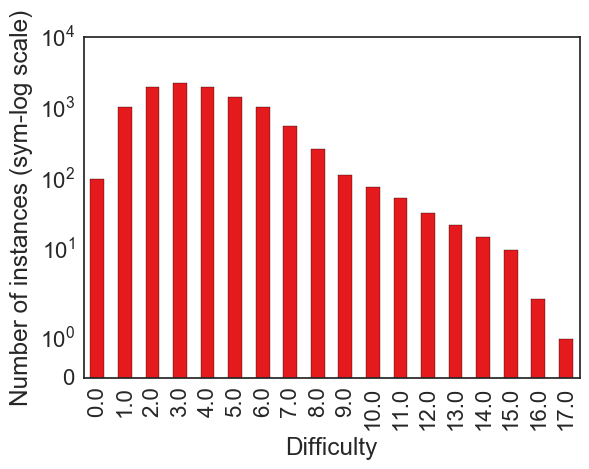

Number of instances per difficulty:
 0.0       99
1.0     1020
2.0     1984
3.0     2269
4.0     2000
5.0     1448
6.0     1023
7.0      559
8.0      260
9.0      112
10.0      76
11.0      53
12.0      33
13.0      22
14.0      15
15.0      10
16.0       2
17.0       1
dtype: int64
Average difficulty: 3.88
Median difficulty: 4.00


In [ ]:
result = df.groupby(df[solvers].max(axis=1) - df["best"]).size()
result.plot(kind="bar")
plt.yscale("symlog")
plt.xlabel("Difficulty")
plt.ylabel("Number of instances (sym-log scale)")
plt.show()
print("Number of instances per difficulty:\n", result)
print("Average difficulty: %.02f" % (df[solvers].max(axis=1) - df["best"]).mean())
print("Median difficulty: %.02f" % (df[solvers].max(axis=1) - df["best"]).median())

### Correlation between the difficulty and the size of the best pagination

Note that this measure of difficulty is intrinsically correlated to the size of the best pagination:

Pearson: 0.777.


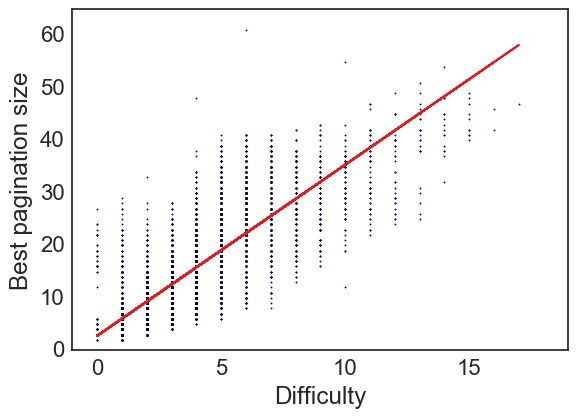

In [ ]:
x = df[solvers].max(axis=1) - df["best"]
y = df["best"]
axes = plt.gca()
axes.set_xlim(-1, 19)
axes.set_ylim(0, 65)
plt.xlabel("Difficulty")
plt.ylabel("Best pagination size")
plt.scatter(x, y, marker="o", s=1)
plot_linear_regression(x, y)

## [Sec. 4.3] Predicting the difficulty of a given instance

**Conjecture 2.** The difficulty of a given random instance is strongly correlated to the density of its shared symbols, or **average multiplicity**.

### [Fig. 4] Number of instances by average multiplicity

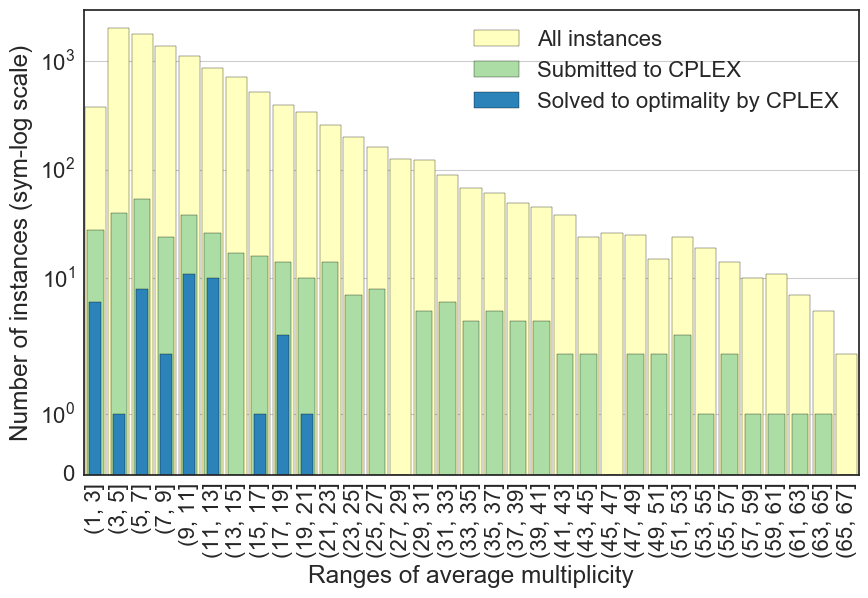

In [ ]:
plt.figure(figsize=(10,6))

range_width = 2
ranges = np.arange(1, df["avgMultiplicity"].max() + range_width, range_width)

slices = pd.cut(df["avgMultiplicity"], ranges)
instances_per_slice = df.groupby(slices).size()
instances_per_slice.plot(kind="bar", width=0.9, color="#ffffbf")

cplex_instances = df[df["cplexOpt"].notnull() | df["cplexLB"].notnull() | df["cplexUB"].notnull()]
cplex_slices = pd.cut(cplex_instances["avgMultiplicity"], ranges)
cplex_instances.groupby(cplex_slices).size().plot(kind="bar", width=0.7, color='#abdda4')

cplex_solved_instances = df[df["cplexOpt"].notnull()]
cplex_solved_slices = pd.cut(cplex_solved_instances["avgMultiplicity"], ranges)
cplex_solved_instances.groupby(cplex_solved_slices).size().plot(kind="bar", width=0.5, color="#2b83ba")

plt.xlabel("Ranges of average multiplicity")
plt.ylabel("Number of instances (sym-log scale)")
plt.yscale('symlog')
axes = plt.gca()
axes.set_ylim(0, 3000)
plt.tick_params(axis='x', which='both', bottom='off', top='off')

axes.yaxis.grid(True)

plt.legend(["All instances", "Submitted to CPLEX", "Solved to optimality by CPLEX"])
plt.savefig(os.path.join(OUTPUT_PATH, "count_by_multiplicity.pdf"), bbox_inches='tight')

In [ ]:
range_width = 1
ranges = np.arange(1, df["avgMultiplicity"].max() + range_width, range_width)
slices = pd.cut(df["avgMultiplicity"], ranges)
instances_per_slice = df.groupby(slices).size()
for start in (4, 23, 53):
    n = instances_per_slice[range_width * (start - 1)]
    print("There are %d instances whose average multiplicity lies between %s and %s." % (n, start, start + range_width))

There are 1119 instances whose average multiplicity lies between 4 and 5.
There are 107 instances whose average multiplicity lies between 23 and 24.
There are 10 instances whose average multiplicity lies between 53 and 54.


In [ ]:
(a, b) = (1, 9)
rate = 100.0 * sum(instances_per_slice[a-1:b-1]) / len(df)
print("%0.2f %% of the instances concentrate between average multiplicities %s and %s." % (rate, a, b))

51.29 % of the instances concentrate between average multiplicities 1 and 9.


### [Fig. 5] Average difficulty by average multiplicity

Pearson: 0.986.


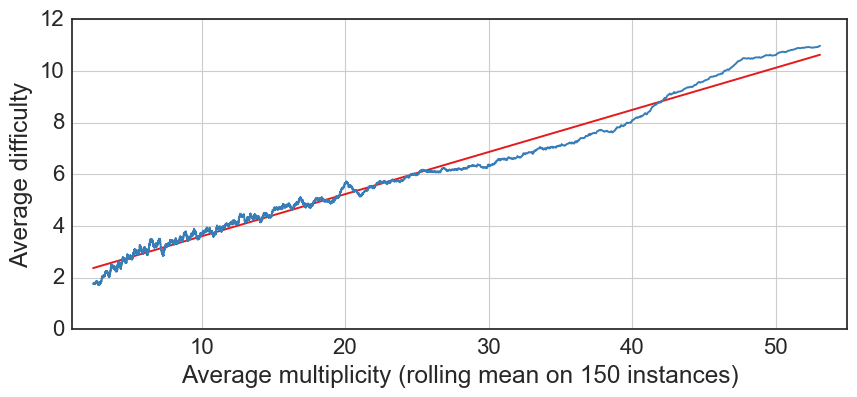

In [ ]:
plt.figure(figsize=(10, 4))
x = pd.Series.rolling(sorted_df["avgMultiplicity"], WINDOW, center=True).mean().dropna()
y = pd.Series.rolling(sorted_df[solvers].max(axis=1) - sorted_df["best"], WINDOW, center=True).mean().dropna()
axes = plt.gca()
axes.set_xlim([1, 55])
plot_linear_regression(x, y)
plt.plot(x, y)
plt.xlabel("Average multiplicity (rolling mean on %s instances)" % WINDOW)
plt.ylabel("Average difficulty")
plt.grid()
plt.savefig(os.path.join(OUTPUT_PATH, "difficulty_by_multiplicity.pdf"), bbox_inches='tight')

The dispersion of the pagination sizes could have been measured in several other ways, for instance with the standard deviation (below). The correlation is not significantly worse:

Pearson: 0.982.


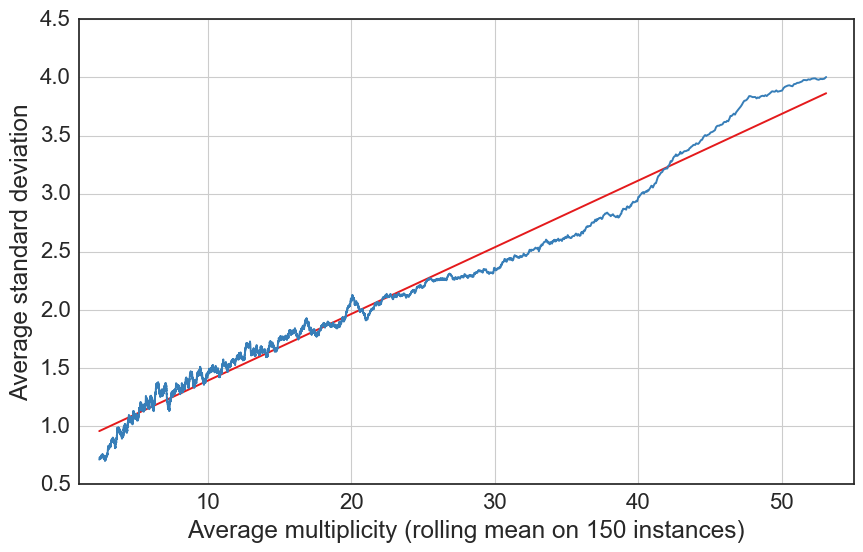

In [ ]:
plt.figure(figsize=(10, 6))
x = pd.Series.rolling(sorted_df["avgMultiplicity"], WINDOW, center=True).mean().dropna()
y = pd.Series.rolling(sorted_df[solvers].std(axis=1), WINDOW, center=True).mean().dropna()
axes = plt.gca()
axes.set_xlim([1, 55])
plot_linear_regression(x, y)
plt.plot(x, y)
plt.xlabel("Average multiplicity (rolling mean on %s instances)" % WINDOW)
plt.ylabel("Average standard deviation")
plt.grid()
plt.show()

# [Sec. 4.4] Discussion

## [Sec. 4.4.1] Behavior of the integer program

In [ ]:
cplex_instances = df[df["cplexOpt"].notnull() | df["cplexLB"].notnull() | df["cplexUB"].notnull()]
print("%s instances (%.2f %%) submitted to CPLEX." % (len(cplex_instances), 100.0 * len(cplex_instances)/len(df)))

342 instances (3.11 %) submitted to CPLEX.


In [ ]:
print("CPLEX's success in less than one hour: %s instances (%.1f %%)." % (df["cplexOpt"].count(), 100.0 * df["cplexOpt"].count() / len(cplex_instances)))

CPLEX's success in less than one hour: 43 instances (12.6 %).


In [ ]:
for above in (13, 20):
    cplex_instances_above = cplex_instances[df["avgMultiplicity"] > above]
    print("CPLEX's success in less than one hour above an average multiplicity of %s: %.1f %%." % (above, 100.0 * cplex_instances_above["cplexOpt"].count() / len(cplex_instances_above)))

CPLEX's success in less than one hour above an average multiplicity of 13: 3.8 %.
CPLEX's success in less than one hour above an average multiplicity of 20: 0.0 %.


In [ ]:
cplex_results = df[df["cplexOpt"].notnull() | df["cplexUB"].notnull()][["cplexOpt","cplexUB","pageCount"]]
print("All the %s instances for which CPLEX has found either a solution, either an upper bound:" % len(cplex_results))
cplex_results

All the 51 instances for which CPLEX has found either a solution, either an upper bound:


cplexOpt  cplexUB  pageCount
filename                i                              
C015_A020_T020_P00.json 0       2.0      NaN          2
                        1       4.0      NaN          4
                        2       8.0      NaN          8
                        3       2.0      NaN          2
                        4       3.0      NaN          3
                        5       8.0      NaN          8
C015_A020_T050_P00.json 0       3.0      NaN          3
                        3       3.0      NaN          3
                        4       NaN      7.0          6
C015_A020_T080_P00.json 0       3.0      NaN          3
                        3       3.0      NaN          3
C015_A050_T020_P00.json 0       NaN      8.0          8
                        1       7.0      NaN          7
                        2       NaN      7.0          7
                        3       NaN      8.0          8
                        5       7.0      NaN          7
C015_A050_T050_P00.json 0       NaN      6.0          6
                        3       5.0      NaN          6
C015_A050_T080_P00.json 2       NaN      7.0          8
C020_A025_T025_P00.json 0       3.0      NaN          3
                        1       4.0      NaN          5
                        3       2.0      NaN          2
                        4       4.0      NaN          4
C020_A025_T055_P00.json 0       4.0      NaN          4
                        3       3.0      NaN          3
C020_A025_T085_P00.json 3       4.0      NaN          4
C025_A030_T030_P00.json 0       3.0      NaN          3
                        1       5.0      NaN          5
                        3       3.0      NaN          3
                        4       5.0      NaN          5
C025_A030_T060_P00.json 0       3.0      NaN          3
                        3       3.0      NaN          3
C025_A030_T090_P00.json 0       4.0      NaN          4
                        3       4.0      NaN          4
C025_A060_T030_P00.json 4       5.0      NaN          5
C030_A035_T035_P00.json 0       2.0      NaN          3
                        3       3.0      NaN          3
C030_A035_T065_P00.json 0       3.0      NaN          3
                        3       3.0      NaN          3
C030_A035_T095_P00.json 0       NaN      4.0          4
C035_A040_T040_P00.json 0       3.0      NaN          3
                        3       3.0      NaN          3
C035_A040_T100_P00.json 3       NaN      4.0          5
C040_A045_T045_P00.json 0       3.0      NaN          3
                        3       3.0      NaN          3
C040_A045_T075_P00.json 0       4.0      NaN          4
C045_A050_T050_P00.json 0       3.0      NaN          3
                        3       3.0      NaN          3
C045_A050_T080_P00.json 0       3.0      NaN          4
C050_A055_T055_P00.json 0       3.0      NaN          3
                        3       3.0      NaN          3

## [Sec. 4.4.2] Comparison of the heuristic methods

### [Fig. 6] Performance of the main heuristics

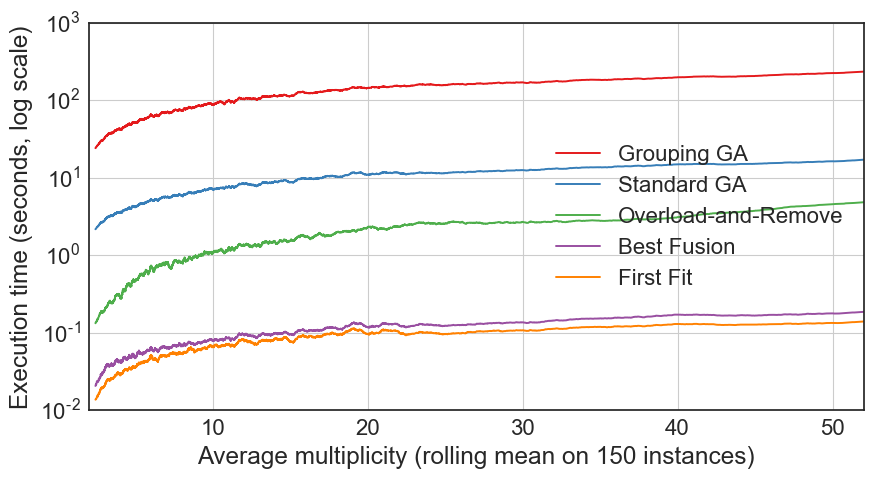

In [ ]:
x = pd.Series.rolling(sorted_df["avgMultiplicity"], WINDOW, center=True).mean()
plt.figure(figsize=(10,5))
axes = plt.gca()
axes.set_xlim([2, 52])
for time in times:
    solver_name = time[len("times"):]
    if solver_name in EXCLUDED_SOLVER_NAMES:
        continue
    y = pd.Series.rolling(sorted_df[time], WINDOW, center=True).mean()
    plt.plot(x, y, label=SOLVER_NAMES[solver_name])
plt.yscale('log')
plt.xlabel("Average multiplicity (rolling mean on %s instances)" % WINDOW)
plt.ylabel("Execution time (seconds, log scale)")
plt.grid()
plt.savefig(os.path.join(OUTPUT_PATH, "speed_by_multiplicity.pdf"), bbox_inches='tight')
plt.legend(loc=7) # legend not plotted for the paper version
plt.show()

In [ ]:
contents = [
    df[times].min().map('{:,.2f}'.format),
    df[times].max().map('{:,.2f}'.format),
    df[times].mean().map('{:,.2f}'.format),
    df[times].std().map('{:,.2f}'.format)
]
digest = pd.DataFrame(contents, index = ["min", "max", "mean", "std"])
digest.columns = SOLVER_NAMES.values()
print("Basic aggregations on execution times (in seconds):")
digest

Basic aggregations on execution times (in seconds):


,Grouping GA,Standard GA,Overload-and-Remove,Overload-and-Remove (with presort),Best Fusion,First Fit
min,2.22,1.32,0.01,0.01,0.01,0.01
max,362.85,32.78,9.38,9.77,0.50,0.60
mean,91.02,7.13,1.18,1.13,0.08,0.06
std,53.34,3.95,1.13,1.10,0.05,0.04


### [Fig. 7] Relative quality of the five main heuristics

The outcomes are plotted at $y = \frac{\mathrm{best~size}}{\mathrm{size}}$, with $y=1$ corresponding to the best known solution (which is either the optimal or the best feasible solution found by CPLEX, or the smallest approximation calculated for the given instance).

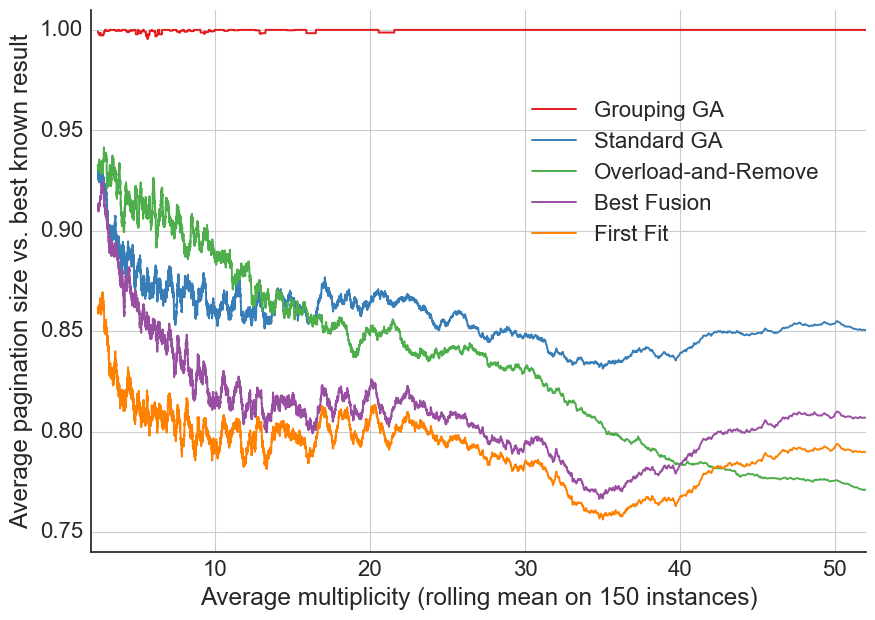

In [ ]:
x = pd.Series.rolling(sorted_df["avgMultiplicity"], WINDOW, center=True).mean()
plt.figure(figsize=(10,7))
axes = plt.gca()
axes.set_xlim([2, 52])
axes.set_ylim([0.74, 1.01])
axes.spines['right'].set_visible(False)
axes.spines['top'].set_visible(False)
for solver in solvers:
    solver_name = solver[len("solvers"):]
    if solver_name in EXCLUDED_SOLVER_NAMES:
        continue
    ratio = sorted_df["best"] / sorted_df[solver]
    y = pd.Series.rolling(ratio, WINDOW, center=True).mean()
    plt.plot(x, y, label=SOLVER_NAMES[solver_name])
plt.xlabel("Average multiplicity (rolling mean on %s instances)" % WINDOW)
plt.ylabel("Average pagination size vs. best known result")
plt.grid()

# move the legend to an empty place
legend = plt.legend(loc=7)
plt.draw()
bb = legend.legendPatch.get_bbox().inverse_transformed(axes.transAxes)
bb.set_points([[bb.x0 - 0.02, bb.y0 + 0.2], [bb.x1 - 0.02, bb.y1 + 0.2]])
legend.set_bbox_to_anchor(bb)

plt.savefig(os.path.join(OUTPUT_PATH, "relative_size_by_multiplicity.pdf"), bbox_inches='tight')

## Exact algorithms vs. heuristics

The column `pageCount` gives the smallest pagination size found by the various **heuristics**:

In [ ]:
assert len(df[df["pageCount"] != df[solvers].min(axis=1)]) == 0

Hence, the optimal value found by CPLEX may be lesser than this one:

In [ ]:
suboptimal_instances_1 = df[df["cplexOpt"] < df["pageCount"]][["cplexOpt", "pageCount"] + solvers]
suboptimal_instances_1.columns = ["cplexOpt", "pageCount"] + list(SOLVER_NAMES.values())
print("The optimal solution is better than the best approximation for these %s instances:" % len(suboptimal_instances_1))
suboptimal_instances_1

The optimal solution is better than the best approximation for these 4 instances:


,,cplexOpt,pageCount,Grouping GA,Standard GA,Overload-and-Remove,Overload-and-Remove (with presort),Best Fusion,First Fit
filename,i,,,,,,,,
C015_A050_T050_P00.json,3,5.0,6,6,7,6,6,6,8
C020_A025_T025_P00.json,1,4.0,5,5,5,5,5,6,6
C030_A035_T035_P00.json,0,2.0,3,3,3,3,3,3,3
C045_A050_T080_P00.json,0,3.0,4,4,4,4,4,5,5


It may happen that the upper bound found by CPLEX is less than the best page count found by the heuristics. In this case, we know that there exists a better pagination (although CPLEX cannot prove its optimality):

In [ ]:
suboptimal_instances_2 = df[df["cplexUB"] < df["pageCount"]][["cplexUB", "pageCount"] + solvers]
suboptimal_instances_2.columns = ["cplexOpt", "pageCount"] + list(SOLVER_NAMES.values())
print("For %s more instances, we know that the best approximation is not optimal:" % len(suboptimal_instances_2))
suboptimal_instances_2

For 2 more instances, we know that the best approximation is not optimal:


,,cplexOpt,pageCount,Grouping GA,Standard GA,Overload-and-Remove,Overload-and-Remove (with presort),Best Fusion,First Fit
filename,i,,,,,,,,
C015_A050_T080_P00.json,2,7.0,8,8,10,8,8,9,11
C035_A040_T100_P00.json,3,4.0,5,5,5,5,5,6,6


The column `best` gives the minimum pagination sizes found by the heuristics and CPLEX (including the upper bound):

In [ ]:
df[df["best"] < df["pageCount"]][["best", "pageCount"]]

,,best,pageCount
filename,i,,
C015_A050_T050_P00.json,3,5.0,6
C015_A050_T080_P00.json,2,7.0,8
C020_A025_T025_P00.json,1,4.0,5
C030_A035_T035_P00.json,0,2.0,3
C035_A040_T100_P00.json,3,4.0,5
C045_A050_T080_P00.json,0,3.0,4


In [ ]:
count = len(suboptimal_instances_1) + len(suboptimal_instances_2)
print("All in all, ILP improved on the heuristics in %s cases" % count, end=" ")
print("(%.02f %% of the %s selected instances)." % (100.0 * count / len(cplex_instances), len(cplex_instances)))

All in all, ILP improved on the heuristics in 6 cases (1.75 % of the 342 selected instances).


## Grouping GA vs. the other heuristics

In [ ]:
prefix = ["avgMultiplicity", "pageCount"]
columns = [
    "solversGeneticGroup",
    "solversGeneticStandard",
    "solversOverloadAndRemove",
    "solversOverloadAndRemovePresort"
]
bad_gga = df[df["pageCount"] < df["solversGeneticGroup"]][prefix + columns]
for column in columns[1:]:
    bad_gga[column] = bad_gga[column][bad_gga[column] < bad_gga["solversGeneticGroup"]]
bad_gga.columns = prefix + [SOLVER_NAMES[column[len("solvers"):]] for column in columns]
print("In %.02f %% of the cases," % (100.0 - 100.0 * len(bad_gga) / len(df)),)
print("Grouping GA was the best heuristics, except on these %s instances" % len(bad_gga), end=" ")
print("(greater values erased for clarity, sorted by increasing average multiplicity).")
bad_gga.sort_values(by="avgMultiplicity").fillna("")

In 99.64 % of the cases,
Grouping GA was the best heuristics, except on these 40 instances (greater values erased for clarity, sorted by increasing average multiplicity).


avgMultiplicity  pageCount  Grouping GA  \
filename                i                                            
C015_A060_T050_P00.json 1             2.33          6            7   
C015_A095_T090_P00.json 1             2.67         11           12   
C015_A050_T045_P00.json 0             2.72          5            6   
C015_A085_T095_P00.json 3             3.09         11           12   
C015_A080_T100_P00.json 3             3.65         12           13   
C020_A090_T075_P00.json 2             3.89         12           13   
C020_A100_T085_P00.json 4             4.44         16           17   
C020_A100_T095_P00.json 2             4.49         16           17   
                        4             4.66         16           17   
C015_A020_T035_P00.json 0             4.95          2            3   
C015_A055_T100_P00.json 2             5.15         10           11   
                        0             5.18         10           11   
C015_A100_T080_P00.json 0             5.24         29           30   
C020_A090_T095_P00.json 4             5.27         16           17   
C015_A040_T080_P00.json 2             5.50          6            7   
C020_A025_T030_P00.json 0             5.60          2            3   
C015_A020_T045_P00.json 3             5.70          2            3   
C020_A080_T095_P00.json 4             5.83         15           16   
C030_A095_T080_P00.json 0             6.02         13           14   
C025_A095_T095_P00.json 0             6.09         16           17   
C030_A075_T070_P00.json 2             6.21          9           10   
C030_A035_T040_P00.json 3             6.23          2            3   
C030_A095_T090_P00.json 2             7.17         15           16   
C030_A080_T095_P00.json 4             7.63         12           13   
C025_A075_T090_P00.json 2             7.65         15           16   
C020_A060_T100_P00.json 2             7.78         13           14   
C035_A100_T100_P00.json 4             8.09         15           16   
C030_A075_T085_P00.json 2             8.15         12           13   
C015_A075_T095_P00.json 1             8.49         33           34   
C025_A070_T095_P00.json 0             8.51         14           15   
C020_A055_T100_P00.json 4             9.44         14           15   
C015_A060_T090_P00.json 5             9.45         27           28   
C035_A085_T100_P00.json 2             9.48         14           15   
C015_A060_T090_P00.json 1             9.77         29           30   
C030_A065_T100_P00.json 4             9.85         11           12   
C040_A080_T090_P00.json 2            10.71         12           13   
C015_A055_T095_P00.json 1            11.36         30           31   
C015_A050_T100_P00.json 1            12.80         28           29   
C045_A050_T060_P00.json 3            13.08          3            4   
C015_A045_T100_P00.json 5            14.87         30           31   

                          Standard GA Overload-and-Remove  \
filename                i                                   
C015_A060_T050_P00.json 1                                   
C015_A095_T090_P00.json 1                              11   
C015_A050_T045_P00.json 0                                   
C015_A085_T095_P00.json 3                              11   
C015_A080_T100_P00.json 3                              12   
C020_A090_T075_P00.json 2                                   
C020_A100_T085_P00.json 4                                   
C020_A100_T095_P00.json 2                              16   
                        4                              16   
C015_A020_T035_P00.json 0           2                       
C015_A055_T100_P00.json 2                                   
                        0                              10   
C015_A100_T080_P00.json 0                                   
C020_A090_T095_P00.json 4                              16   
C015_A040_T080_P00.json 2                                   
C020_A025_T030_P00.json 0           2            

In [ ]:
for column in bad_gga.columns[len(prefix) + 1:]:
    count = bad_gga[column].count()
    print("%s produced a better pagination than Grouping GA on %s instances (%.03f %%)." % (column, count, (100.0 * count / len(df))))

Standard GA produced a better pagination than Grouping GA on 4 instances (0.036 %).
Overload-and-Remove produced a better pagination than Grouping GA on 22 instances (0.200 %).
Overload-and-Remove (with presort) produced a better pagination than Grouping GA on 24 instances (0.218 %).
